In [55]:
import cv2 as cv
import numpy as np
import math
from itertools import combinations
import matplotlib.pyplot as plt

In [56]:
# Lê a imagem e cria uma imagem de mesmo tamanho toda preta

img = cv.imread(cv.samples.findFile('Goalball.png'))
height, width, _ = img.shape
blank_img = np.zeros((height,width,3), np.uint8)
blank_img = cv.cvtColor(blank_img,cv.COLOR_BGR2GRAY)

In [57]:
# Converte pra HSV
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

#Cria uma máscara que detecta a cor do campo
mask = cv.inRange(hsv, (0,0,100), (50,150,200))

#Cria uma imagem onde a máscara foi aplicada
img_masked = cv.bitwise_and(img, img, mask=mask)

In [58]:
# Pré Processamento para o K-means
Z = img_masked.reshape((-1,3))
Z = np.float32(Z)

# Definindo os parâmetros do K-means
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2

# Aplicando o K-Means
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

# Recriando a imagem filtrada com apenas 2 cores
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

# Dilatando a imagem para preencher buraquinhos criados na máscara
res2 = cv.dilate(res2, None)

# Levar para tons de cinza e gerar uma imagem binária
res2 = cv.cvtColor(res2,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(res2, 10, 255, cv.THRESH_BINARY)

# Aplicar o Canny e dilatá-lo
edges = cv.Canny(thresh,150,300,apertureSize = 3, L2gradient=True)
edges = cv.dilate(edges, None)
cv.imwrite('Canny.jpg',edges)
cv.imwrite('res2.jpg',thresh)

True

In [ ]:
# Aplica o Hough Lines Probabilístico
# Calcula o coeficiente angular
# Caso as linhas tenham o coeficiente angular desejado, calcule a linha mais 
# a direita e mais a esquerda
# Salve as duas linhas na imagem toda preta criada

highest_v = [0,None]
lowest_v = [3000, None]
lines = cv.HoughLinesP(edges,1,np.pi/180,50,minLineLength=100,maxLineGap=6)
for line in lines:
    x1,y1,x2,y2 = line[0]
    if x1 == x2:
        continue
    elif y1 == y2:
        continue
    else:
        m = (y2-y1)/(x2-x1)

        if abs(y2-y1) > 50 and abs(m) <2:
            b = y1-(m*x1)
            line_y = lambda x: math.floor((m*x)+b)
            line_x = lambda y: math.floor((y-b)/m)

            if line_y(height/2) > highest_v[0]:
                highest_v[0] = line_y(height/2)
                highest_v[1] = ((0,line_y(0)),(width,line_y(width)))
            if line_y(height/2) < lowest_v[0]:
                lowest_v[0] = line_y(height/2)
                lowest_v[1] = ((0,line_y(0)),(width,line_y(width)))

cv.line(blank_img,(highest_v[1][0]),(highest_v[1][1]),(255,255,255),1)
cv.line(blank_img,(lowest_v[1][0]),(lowest_v[1][1]),(255,255,255),1)
cv.line(img,(highest_v[1][0]),(highest_v[1][1]),(0,0,255),2, lineType=cv.LINE_AA)
cv.line(img,(lowest_v[1][0]),(lowest_v[1][1]),(0,0,255),2,lineType=cv.LINE_AA)

In [ ]:
# Aplica o findContours para encontrar os contornos presentes na imagem
# Ordena os contornos do em ordem decrescente
# Analisa os 3 maiores contornos, buscando a linha horizontal mais acima e mais 
# abaixo
# Salva as duas linhas encontradas na imagem toda preta

highest_h = 0
lowest_h = 30000
contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)
for i in range(3):
    quadra = contours[i]
    x,y,w,h = cv.boundingRect(quadra)
    if (y+h) > highest_h:
        highest_h = (y+h)
    if y > highest_h:
        highest_h = y
    if (y+h) < lowest_h:
        lowest_h = (y+h)
    if y < lowest_h:
        lowest_h = y
cv.line(blank_img,(0,lowest_h),(width, lowest_h),(255,255,255),1)
cv.line(blank_img,(0,highest_h),(width, highest_h),(255,255,255),1)
cv.line(img,(0,lowest_h),(width, lowest_h),(0,0,255),2)
cv.line(img,(0,highest_h),(width, highest_h),(0,0,255),2)

In [61]:
# Aplica a deteção de cantos de Harris
# Encontra as coordenadas dos cantos
# Liga os cantos com retas (filtrando as diagonais)

gray = np.float32(blank_img)
dst = cv.cornerHarris(gray,2,3,0.01)
blank_img[:] = 0
blank_img[dst==dst.max()] = 255
corners = np.argwhere(blank_img)
corners = corners.astype(np.int32)

for i in range(len(corners)):
    corners[i] = np.flip(corners[i])

for comb in combinations(corners, 2):
    m = (comb[1][1] - comb[0][1])/(comb[1][0] - comb[0][0])
    alpha = math.floor(math.degrees(math.atan(m)))
    if abs(alpha) < 20 or abs(alpha) > 30:
        cv.line(img, comb[0], comb[1], (0,255,255), 10)

<function matplotlib.pyplot.show(close=None, block=None)>

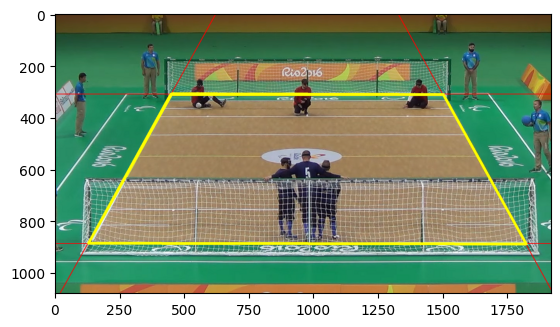

In [62]:
img2 = img[:,:,::-1]
plt.imshow(img2)
plt.show